**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

In [71]:
#import some necessary libraries

import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
#from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor



import xgboost as xgb
import lightgbm as lgb





pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

In [72]:
#First let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


# a.Data description & Visualization (EDA) 

In [73]:
##display the first five rows of the test dataset.
test.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [74]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [76]:
train.isnull().any()

MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
Street           False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 80, dtype: bool

We see that there are Null values let's found out which

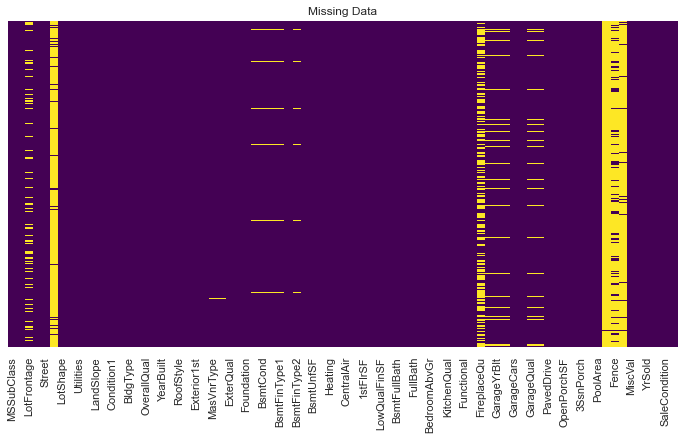

In [77]:
plt.figure(figsize=(12,6))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data')
plt.show()


In [78]:
#Check the percentage of missing values desceding to decide what to do.
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageYrBlt,81,0.055
GarageCond,81,0.055
GarageType,81,0.055
GarageFinish,81,0.055


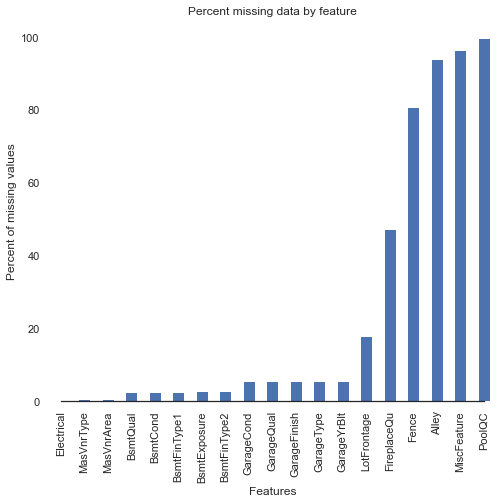

In [79]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

Let's plot how SalePrice relates to some of the features in the dataset

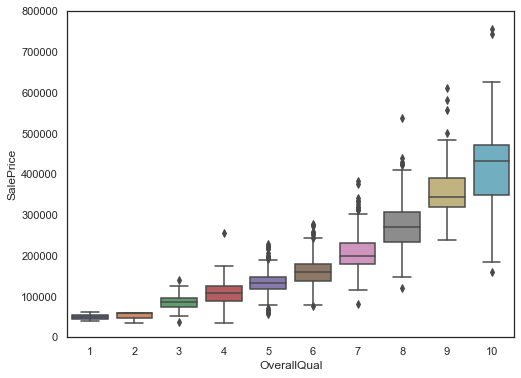

In [80]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

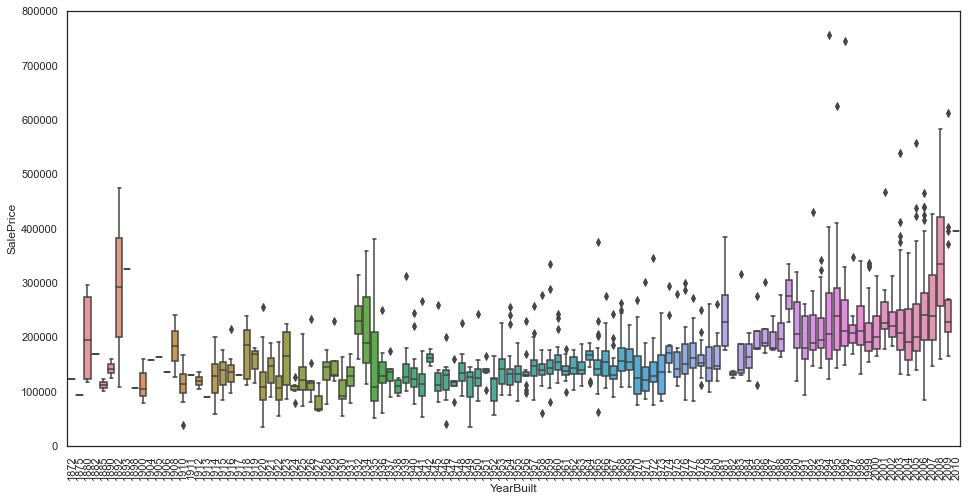

In [81]:
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

It seems that some old very old houses have more value at specific years

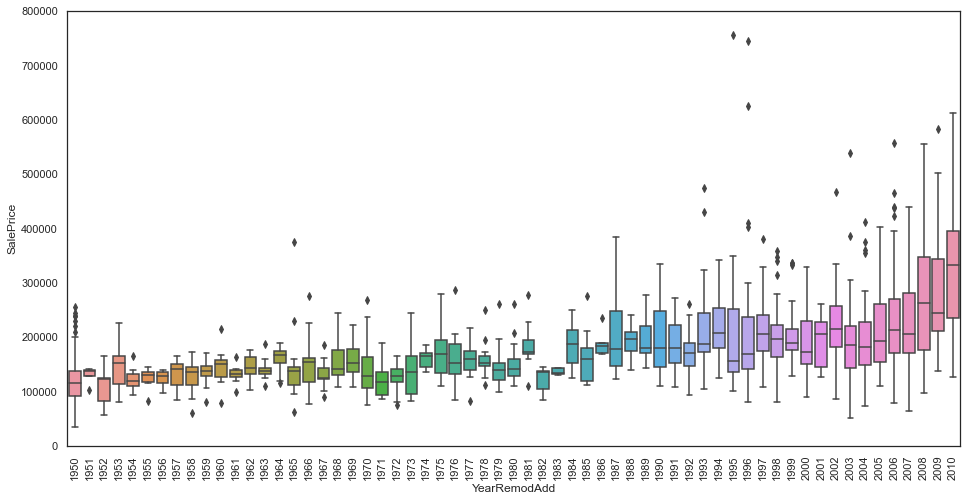

In [82]:
var = 'YearRemodAdd'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Remodelation is also something to consider.The more recent it is the higher is the price 

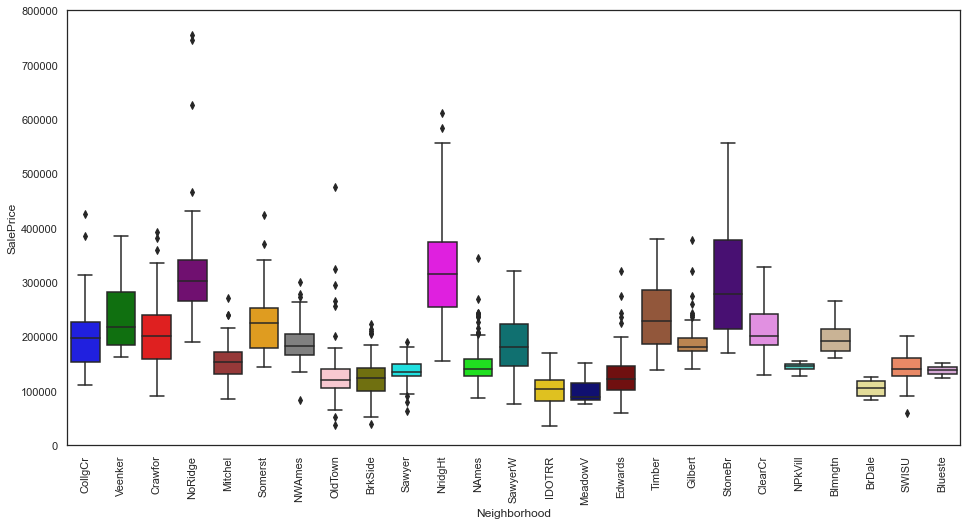

In [86]:
# create a dictionary of neighborhoods and corresponding colors

neighborhood_colors = {
    'CollgCr': 'blue',
    'Veenker': 'green',
    'Crawfor': 'red',
    'NoRidge': 'purple',
    'Mitchel': 'brown',
    'Somerst': 'orange',
    'NWAmes': 'gray',
    'OldTown': 'pink',
    'BrkSide': 'olive',
    'Sawyer': 'cyan',
    'NridgHt': 'magenta',
    'NAmes': 'lime',
    'SawyerW': 'teal',
    'IDOTRR': 'gold',
    'MeadowV': 'navy',
    'Edwards': 'maroon',
    'Timber': 'sienna',
    'Gilbert': 'peru',
    'StoneBr': 'indigo',
    'ClearCr': 'violet',
    'NPkVill': 'turquoise',
    'Blmngtn': 'tan',
    'BrDale': 'khaki',
    'SWISU': 'coral',
    'Blueste': 'plum'
}

var = 'Neighborhood'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette=neighborhood_colors)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)
plt.show()


Let's explore the SalePrice by Living Area and filter it by the Neighborhood afterwards


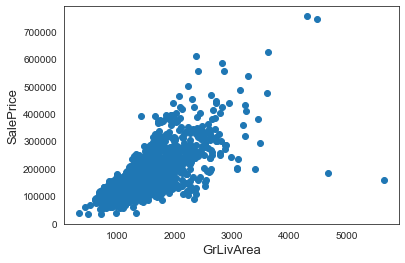

In [13]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


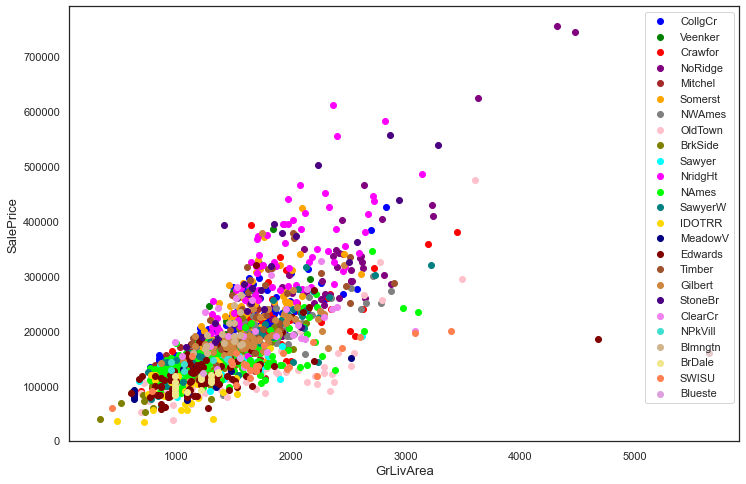

In [85]:
# loop over neighborhoods and plot them separately
for neighborhood in neighborhood_colors:
    neighborhood_data = train[train['Neighborhood'] == neighborhood]
    color = neighborhood_colors[neighborhood]
    ax.scatter(x = neighborhood_data['GrLivArea'], y = neighborhood_data['SalePrice'], c=color, label=neighborhood)

plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.legend()
plt.show()

# b.Data pre-processing & c.Data/feature selection/evaluation or even feature creation/generation.

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180921.20 and sigma = 79415.29



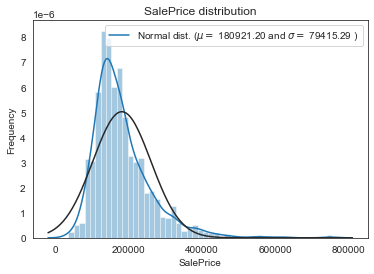

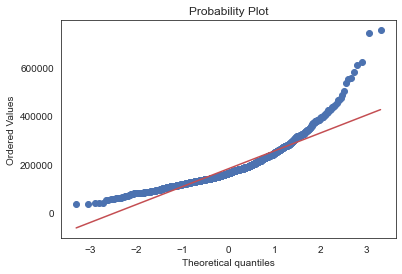

In [14]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

 **Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



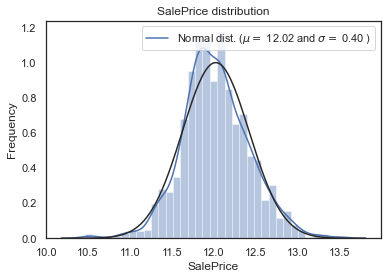

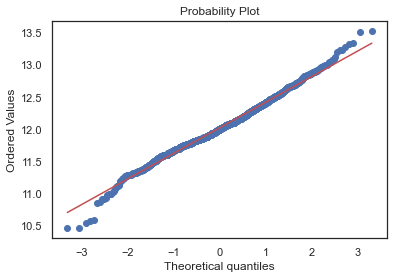

In [91]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()



The skew seems now corrected and the data appears more normally distributed. 

##Features engineering

let's first  concatenate the train and test data in the same dataframe

In [88]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


###Missing Data

In [89]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
FireplaceQu,48.647
LotFrontage,16.650
GarageFinish,5.447
GarageQual,5.447
GarageCond,5.447
GarageYrBlt,5.447


Text(0.5, 1.0, 'Percent missing data by feature')

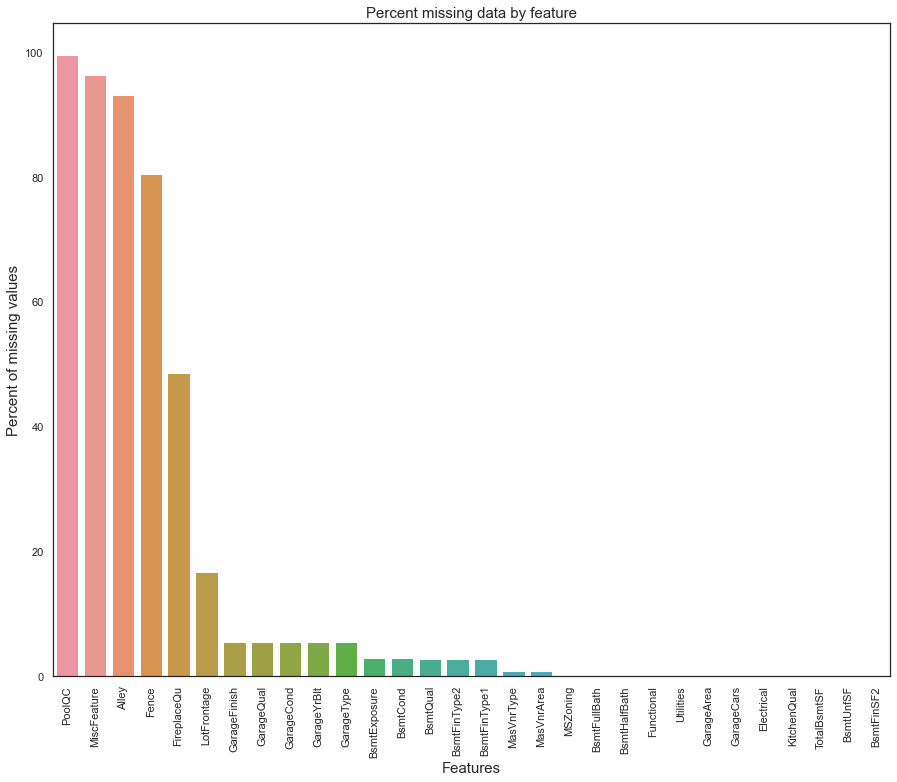

In [90]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


<AxesSubplot:>

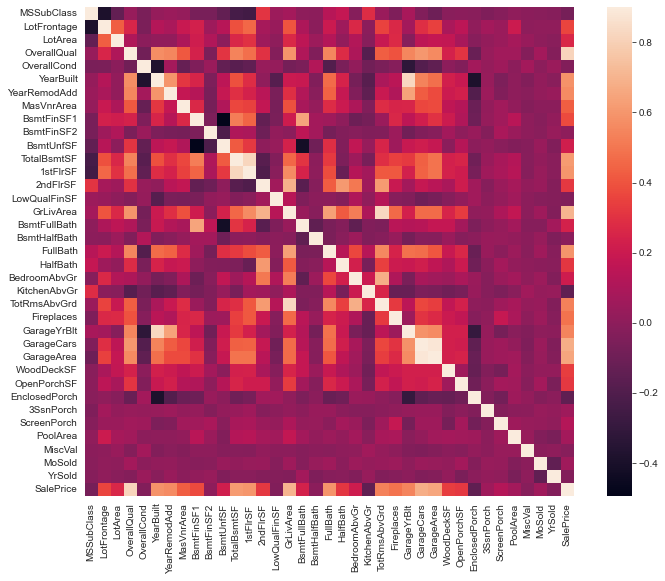

In [19]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

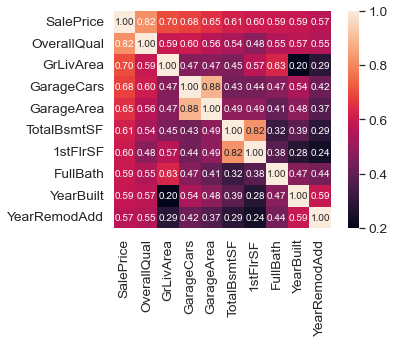

In [20]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

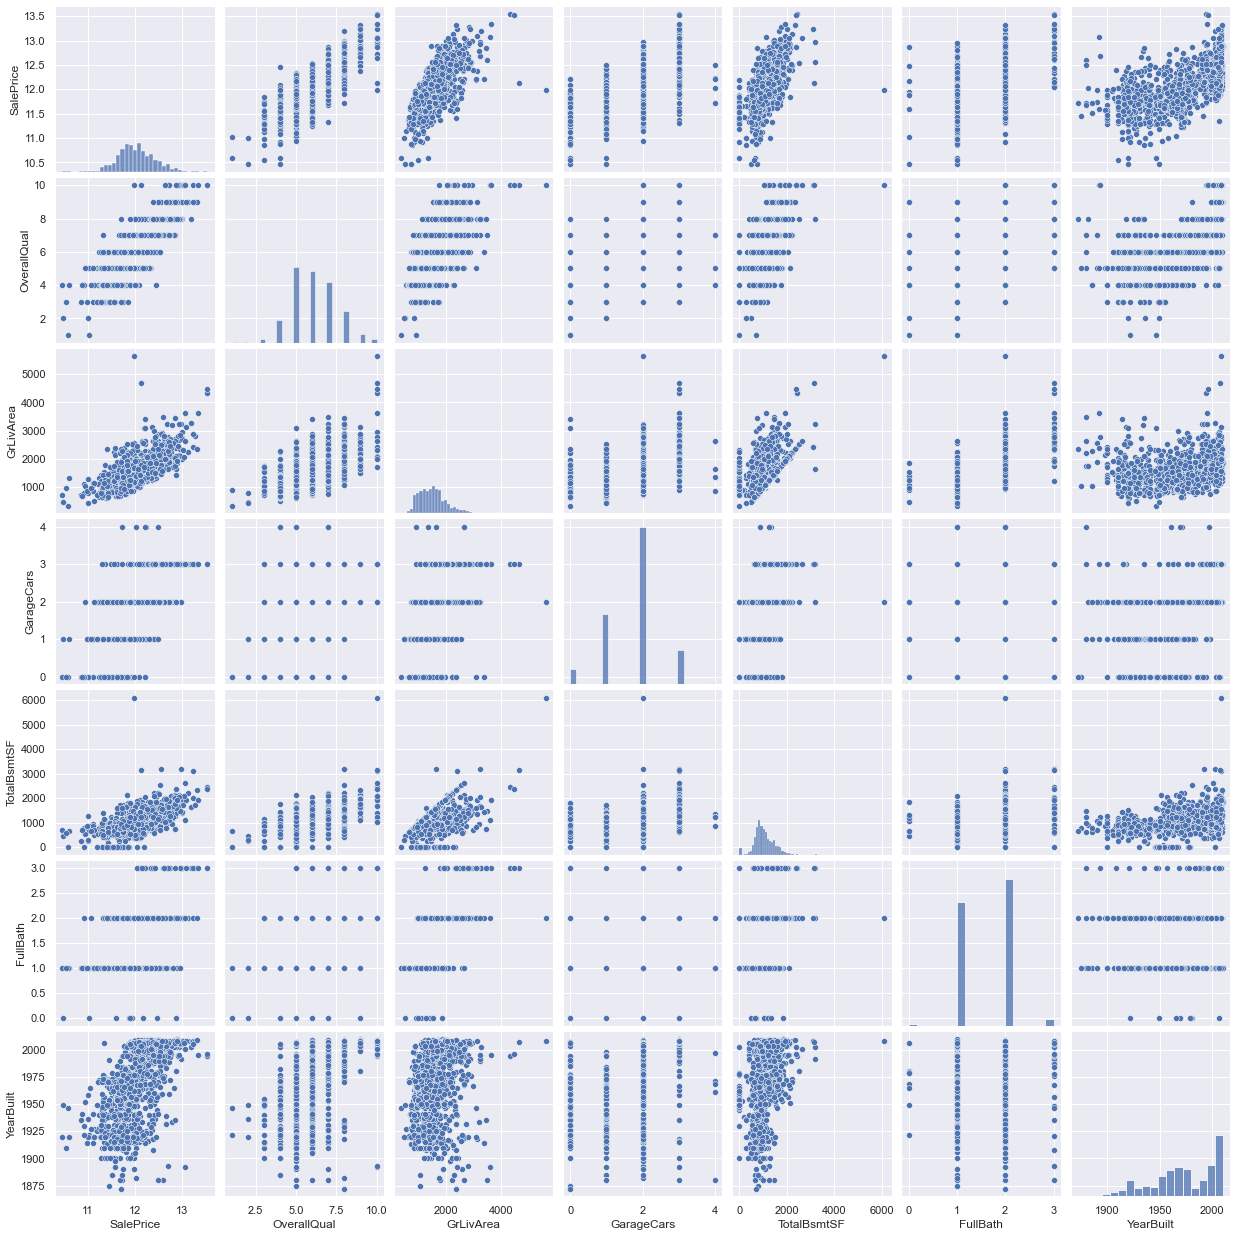

In [21]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

###Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [22]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : data description says NA means "no misc feature"


In [23]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [24]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [25]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [26]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [27]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [28]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [29]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [30]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [31]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [32]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [33]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [34]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [35]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [36]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [37]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [38]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [39]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [40]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Is there any remaining missing value ? 

In [41]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.


###More features engeneering

**Transforming some numerical variables that are really categorical**

In [42]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)



**Label Encoding some categorical variables that may contain information in their ordering set** 

In [46]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2919, 78)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [47]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Getting dummy categorical features**

In [48]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 221)


Getting the new train and test sets. 

In [49]:
train = all_data[:ntrain]
test = all_data[ntrain:]

print("train shape:", train.shape)
print("test shape:", test.shape)


train shape: (1460, 221)
test shape: (1459, 221)


In [50]:
train.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,65.000,8450,1,1,3,0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,5,80.000,9600,1,1,3,0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,10,68.000,11250,1,1,0,0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,11,60.000,9550,1,1,0,0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,10,84.000,14260,1,1,0,0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


#Modelling

**Import libraries**

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb



from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [51]:
# Split data into train and test sets using original indices
X_train = all_data.iloc[:ntrain]
X_test = all_data.iloc[ntrain:]
y_train
y_test = pd.Series([0] * len(X_test))

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)






X_train shape: (1460, 221)
X_test shape: (1459, 221)
y_train shape: (1460,)
y_test shape: (1459,)


# d.Use multiple classifiers and evaluate the parameters of each classifier

In [52]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

In [53]:
def run_regression(X_train, y_train, X_test, y_test, regression_type, degree=None, alpha=None):
    # Create model instance
    if regression_type == "linear":
        model = LinearRegression()
    elif regression_type == "polynomial":
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        model = LinearRegression()
        X_train, X_test = X_train_poly, X_test_poly
    elif regression_type == "lasso":
        model = Lasso(alpha=alpha)
    elif regression_type == "ridge":
        model = Ridge(alpha=alpha)
    elif regression_type == "Decision Tree":
        model = DecisionTreeRegressor(max_depth=alpha)
    elif regression_type == "Random Forest":
        model = RandomForestRegressor(n_estimators=alpha)
    elif regression_type == "Gradient Boosting":
        model = GradientBoostingRegressor(max_depth=alpha)

    # Train model

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {"Regression Type": regression_type, "Degree": degree, "Alpha": alpha, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2 Score": r2}

# Split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression
linear_results = run_regression(X_train, y_train, X_test, y_test, "linear")

# Polynomial regression
poly_results = run_regression(X_train, y_train, X_test, y_test, "polynomial", degree=2)

# Lasso regression
lasso = Lasso()
lasso_params = {"alpha": np.logspace(-5, 2, 8)}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring="neg_mean_squared_error")
lasso_grid.fit(X_train, y_train)
lasso_results = run_regression(X_train, y_train, X_test, y_test, "lasso", alpha=lasso_grid.best_params_["alpha"])

# Ridge regression
ridge = Ridge()
ridge_params = {"alpha": np.logspace(-5, 2, 8)}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring="neg_mean_squared_error")
ridge_grid.fit(X_train, y_train)
ridge_results = run_regression(X_train, y_train, X_test, y_test, "ridge", alpha=ridge_grid.best_params_["alpha"])




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.41258e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.23808e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.06959e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.45931e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAl

{'Regression Type': 'linear', 'Degree': None, 'Alpha': None, 'MSE': 144.40501724730836, 'RMSE': 12.016863869051209, 'MAE': 12.01016040560484, 'R2 Score': 0.0}
{'Regression Type': 'polynomial', 'Degree': 2, 'Alpha': None, 'MSE': 148.4419940564822, 'RMSE': 12.183677361801822, 'MAE': 12.106777703939057, 'R2 Score': 0.0}
{'Regression Type': 'lasso', 'Degree': None, 'Alpha': 0.001, 'MSE': 144.37974122878197, 'RMSE': 12.015812133550606, 'MAE': 12.009638821103579, 'R2 Score': 0.0}


In [69]:
# Create a list of dictionaries with the results
results_list = [linear_results, poly_results, lasso_results]

# Convert the list of dictionaries to a pandas DataFrame
results_df = pd.DataFrame(results_list)

# Set the index of the DataFrame to the "Regression Type" column
results_df.set_index("Regression Type", inplace=True)

# Convert the dictionaries to pandas DataFrames
linear_df = pd.DataFrame(linear_results, index=[0])
poly_df = pd.DataFrame(poly_results, index=[0])
lasso_df = pd.DataFrame(lasso_results, index=[0])

# Concatenate the DataFrames into one table
df = pd.concat([linear_df, poly_df, lasso_df], ignore_index=True)

# Define a function to apply color to the values based on a threshold
def color_positive_green(val, col):
    if col in ['MSE', 'RMSE', 'MAE'] and val == df[col].min():
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color

# Apply the color function to the columns with the respective thresholds
df_ev = df.style.apply(lambda x: [color_positive_green(val, x.name) for val in x], axis=0)

# Display the styled table
df_ev

,Regression Type,Degree,Alpha,MSE,RMSE,MAE,R2 Score
0,linear,None,None,144.405017,12.016864,12.010160,0.000000
1,polynomial,2,None,148.441994,12.183677,12.106778,0.000000
2,lasso,None,0.001000,144.379741,12.015812,12.009639,0.000000


In [58]:
# Decision tree regression
dtree = DecisionTreeRegressor()
dtree_params = {"max_depth": range(1, 11)}
dtree_grid = GridSearchCV(dtree, dtree_params, cv=5, scoring="neg_mean_squared_error")
dtree_grid.fit(X_train, y_train)
dtree_results = run_regression(X_train, y_train, X_test, y_test, "Decision Tree", alpha=dtree_grid.best_params_["max_depth"])

print(dtree_results)



{'Regression Type': 'Decision Tree', 'Degree': None, 'Alpha': 4, 'MSE': 144.44399694719584, 'RMSE': 12.01848563452134, 'MAE': 12.013043095864877, 'R2 Score': 0.0}


In [59]:
# Random forest regression
rforest = RandomForestRegressor()
rforest_params = {"n_estimators": [50, 100, 200], "max_depth": range(1, 11)}
rforest_grid = GridSearchCV(rforest, rforest_params, cv=5, scoring="neg_mean_squared_error")
rforest_grid.fit(X_train, y_train)
rforest_results = run_regression(X_train, y_train, X_test, y_test, "Random Forest", alpha=rforest_grid.best_params_["max_depth"],
degree=rforest_grid.best_params_["n_estimators"])

print(rforest_results)

{'Regression Type': 'Random Forest', 'Degree': 100, 'Alpha': 10, 'MSE': 144.29612344193973, 'RMSE': 12.012332140010937, 'MAE': 12.006461161682408, 'R2 Score': 0.0}


In [60]:
# Gradient boosting regression
gboost = GradientBoostingRegressor()
gboost_params = {"learning_rate": [0.05, 0.1, 0.2], "n_estimators": [50, 100, 200], "max_depth": range(1, 11)}
gboost_grid = GridSearchCV(gboost, gboost_params, cv=5, scoring="neg_mean_squared_error")
gboost_grid.fit(X_train, y_train)
gboost_results = run_regression(X_train, y_train, X_test, y_test, "Gradient Boosting", alpha=gboost_grid.best_params_["max_depth"], degree=gboost_grid.best_params_["n_estimators"])

print(gboost_results)

{'Regression Type': 'Gradient Boosting', 'Degree': 200, 'Alpha': 3, 'MSE': 144.26108556574297, 'RMSE': 12.010873638738481, 'MAE': 12.004491933160402, 'R2 Score': 0.0}


In [61]:
# Convert the dictionaries to pandas DataFrames
linear_df = pd.DataFrame(linear_results, index=[0])
poly_df = pd.DataFrame(poly_results, index=[0])
lasso_df = pd.DataFrame(lasso_results, index=[0])
ridge_df = pd.DataFrame(ridge_results, index=[0])
rforest_df = pd.DataFrame(rforest_results, index=[0])
dtree_df = pd.DataFrame(dtree_results, index=[0])
gboost_df = pd.DataFrame(gboost_results, index=[0])


# Concatenate the DataFrames into one table
df = pd.concat([linear_df, poly_df, lasso_df, ridge_df, rforest_df, dtree_df, gboost_df], ignore_index=True)

# Define a function to apply color to the values based on a threshold
def color_positive_green(val, col):
    if col in ['MSE', 'RMSE', 'MAE'] and val == df[col].min():
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color

# Apply the color function to the columns with the respective thresholds
df_styled = df.style.apply(lambda x: [color_positive_green(val, x.name) for val in x], axis=0)

# Display the styled table
df_styled

,Regression Type,Degree,Alpha,MSE,RMSE,MAE,R2 Score
0,linear,None,None,144.405017,12.016864,12.010160,0.000000
1,polynomial,2,None,148.441994,12.183677,12.106778,0.000000
2,lasso,None,0.001000,144.379741,12.015812,12.009639,0.000000
3,ridge,None,10.000000,144.371521,12.015470,12.009144,0.000000
4,Random Forest,100,10,144.296123,12.012332,12.006461,0.000000
5,Decision Tree,None,4,144.443997,12.018486,12.013043,0.000000
6,Gradient Boosting,200,3,144.261086,12.010874,12.004492,0.000000


In [63]:
train.head(5)

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,65.000,8450,1,1,3,0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,5,80.000,9600,1,1,3,0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,10,68.000,11250,1,1,0,0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,11,60.000,9550,1,1,0,0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,10,84.000,14260,1,1,0,0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


# Should we try stacking the models?


After evaluating the performance of several models using mean squared error (MSE) and root mean squared error (RMSE) scores, it is worth considering the use of ensemble methods, such as stacking. Stacking involves combining the predictions of multiple models to improve performance.

However, before deciding to stack models, it is essential to ensure that the individual models are diverse enough, meaning they make different types of errors. Otherwise, stacking might not improve the overall performance, and it might be better to use a single best-performing model.

One way to check the diversity of the individual models is to analyze the residuals of each model. Residuals are the differences between the actual values and the predicted values.

We can plot the residuals of each model against the predicted values and see if there is any pattern. If there is no pattern and the residuals are randomly scattered around zero, it is a good indication that the model is making different types of errors. However, if there is a pattern in the residuals, it may indicate that the model is biased towards certain types of errors.

In [54]:
# Create Lasso model instance
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train, y_train)

ridge.fit(X_train, y_train)

# Make predictions on test data
y_pred = lasso.predict(X_test)

# Compute performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



In [55]:
# Create Linear Regression model instance
linear = LinearRegression()

# Fit the model
linear.fit(X_train, y_train)

# Create Polynomial Regression model instance
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)

# Create Lasso model instance
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train, y_train)

# Create Ridge model instance
ridge = Ridge(alpha=0.1)

# Fit the model
ridge.fit(X_train, y_train)

# Create Random Forest model instance
rforest = RandomForestRegressor()

# Fit the model
rforest.fit(X_train, y_train)

# Create Decision Tree model instance
dtree = DecisionTreeRegressor()

# Fit the model
dtree.fit(X_train, y_train)

# Create Gradient Boosting model instance
gboost = GradientBoostingRegressor()

# Fit the model
gboost.fit(X_train, y_train)

# Make predictions on test data for Lasso
y_pred_lasso = lasso.predict(X_test)

# Compute performance metrics for Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Make predictions on test data for Ridge
y_pred_ridge = ridge.predict(X_test)

# Compute performance metrics for Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Make predictions on test data for Random Forest
y_pred_rforest = rforest.predict(X_test)

# Compute performance metrics for Random Forest
mse_rforest = mean_squared_error(y_test, y_pred_rforest)
rmse_rforest = np.sqrt(mse_rforest)
mae_rforest = mean_absolute_error(y_test, y_pred_rforest)
r2_rforest = r2_score(y_test, y_pred_rforest)

# Make predictions on test data for Decision Tree
y_pred_dtree = dtree.predict(X_test)

# Compute performance metrics for Decision Tree
mse_dtree = mean_squared_error(y_test, y_pred_dtree)
rmse_dtree = np.sqrt(mse_dtree)
mae_dtree = mean_absolute_error(y_test, y_pred_dtree)
r2_dtree = r2_score(y_test, y_pred_dtree)

# Make predictions on test data for Gradient Boosting
y_pred_gboost = gboost.predict(X_test)

# Compute performance metrics for Gradient Boosting
mse_gboost = mean_squared_error(y_test, y_pred_gboost)
rmse_gboost = np.sqrt(mse_gboost)
mae_gboost = mean_absolute_error(y_test, y_pred_gboost)
r2_gboost = r2_score(y_test, y_pred_gboost)



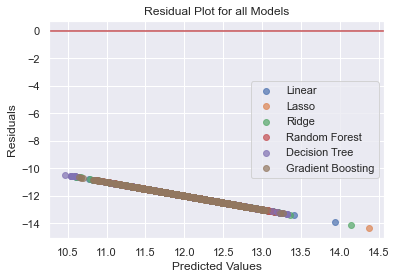

In [56]:
# Make predictions on the test set for each model
y_pred_linear = linear.predict(X_test)
#y_pred_poly = poly_reg.predict(poly_features.transform(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_rforest = rforest.predict(X_test)
y_pred_dtree = dtree.predict(X_test)
y_pred_gboost = gboost.predict(X_test)

# Calculate the residuals for each model
residuals_linear = y_test - y_pred_linear
#residuals_poly = y_test - y_pred_poly
residuals_lasso = y_test - y_pred_lasso
residuals_ridge = y_test - y_pred_ridge
residuals_rforest = y_test - y_pred_rforest
residuals_dtree = y_test - y_pred_dtree
residuals_gboost = y_test - y_pred_gboost

# Plot the residuals for all models
plt.scatter(y_pred_linear, residuals_linear, label="Linear", alpha=0.7)
#plt.scatter(y_pred_poly, residuals_poly, label="Polynomial", alpha=0.7)
plt.scatter(y_pred_lasso, residuals_lasso, label="Lasso", alpha=0.7)
plt.scatter(y_pred_ridge, residuals_ridge, label="Ridge", alpha=0.7)
plt.scatter(y_pred_rforest, residuals_rforest, label="Random Forest", alpha=0.7)
plt.scatter(y_pred_dtree, residuals_dtree, label="Decision Tree", alpha=0.7)
plt.scatter(y_pred_gboost, residuals_gboost, label="Gradient Boosting", alpha=0.7)

plt.title("Residual Plot for all Models")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.show()


There is a pattern in the residuals, which may indicate that the model is biased towards certain types of errors.Let's do a stacked reggression attemp though


In [64]:
X_train = X_train.reset_index().rename(columns={'index': 'Id'}).set_index('Id')
X_test = X_test.reset_index().rename(columns={'index': 'Id'}).set_index('Id')


In [65]:
# Define the base models
models = [DecisionTreeRegressor(max_depth=6),RandomForestRegressor(max_depth=8, n_estimators=200), GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200)]

# Create empty arrays to store the training and validation predictions for each model
train_predictions = np.zeros((X_train.shape[0], len(models)))
val_predictions = np.zeros((X_test.shape[0], len(models)))

# Loop over the models
for i, model in enumerate(models):
    model.fit(X_train, y_train)
        
    # Make predictions on the training and validation sets
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
        
    # Store the predictions in the corresponding arrays
    train_predictions[:, i] = train_preds
    val_predictions[:, i] = val_preds
        
# Train a linear regression meta-model on the training predictions
meta_model = LinearRegression()
meta_model.fit(train_predictions, y_train)

# Make predictions on the validation set using the stacked models
val_stacked = meta_model.predict(val_predictions)

# Convert the predicted sale prices back to their original scale
val_preds_orig = np.exp(val_stacked)

# Calculate the evaluation metrics
mse_train = mean_squared_error(y_train, np.exp(np.mean(train_predictions, axis=1)))
mse_val = mean_squared_error(y_test, val_preds_orig)
rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)
#r2_train = r2_score(y_train, np.exp(np.mean(train_predictions, axis=1)))
#r2_val = r2_score(test, test_preds_orig)

# Print the evaluation metrics
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Validation RMSE: {rmse_val:.2f}")
#print(f"Train R^2: {r2_train:.2f}")
#print(f"Validation R^2: {r2_val:.2f}")


Train RMSE: 194040.28
Validation RMSE: 193531.80


The results are way off so we exclude this option

In [66]:
# Define the base models
models = [GradientBoostingRegressor(max_depth=best_depth, n_estimators=best_n_estimators, learning_rate=best_learning_rate) for best_depth, best_n_estimators, best_learning_rate in zip(gboost_grid.cv_results_['param_max_depth'], gboost_grid.cv_results_['param_n_estimators'], gboost_grid.cv_results_['param_learning_rate'])]

# Split the training set into k folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

y_train = pd.Series(y_train, index=X_train.index)

# Create empty arrays to store the training and test predictions for each model
train_predictions = np.zeros((X_train.shape[0], len(models)))
test_predictions = np.zeros((X_test.shape[0], len(models)))

# Loop over the folds
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train each base model on the training fold
    for j, model in enumerate(models):
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions on the training and validation folds
        train_fold_preds = model.predict(X_train_fold)
        val_fold_preds = model.predict(X_val_fold)
        
        # Store the predictions in the corresponding arrays
        train_predictions[val_index, j] = val_fold_preds
        test_predictions[:, j] += model.predict(X_test) / k
        
# Train a linear regression meta-model on the training predictions
meta_model = LinearRegression()
meta_model.fit(train_predictions, y_train)

# Make predictions on the test set using the stacked models
y_pred = meta_model.predict(test_predictions)

# Convert the predicted sale prices back to their original scale
y_pred = np.exp(y_pred)

# Create a submission file
submission_df = pd.DataFrame({"Id": test_ID, "SalePrice": y_pred})
submission_df.to_csv("Submission.csv", index=False)


In [67]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# Define the base models
models = [DecisionTreeRegressor(max_depth=6), RandomForestRegressor(max_depth=8, n_estimators=200), GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200)]

# Split the training set into k folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)


# Create empty arrays to store the training and test predictions for each model
train_predictions = np.zeros((X_train.shape[0], len(models)))
test_predictions = np.zeros((X_test.shape[0], len(models)))

# Loop over the folds
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train = pd.Series(y_train)
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train each base model on the training fold
    for j, model in enumerate(models):
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions on the training and validation folds
        train_fold_preds = model.predict(X_train_fold)
        val_fold_preds = model.predict(X_val_fold)
        
        # Store the predictions in the corresponding arrays
        train_predictions[val_index, j] = val_fold_preds
        test_predictions[:, j] += model.predict(X_test) / k
        
# Train a linear regression meta-model on the training predictions
meta_model = LinearRegression()
meta_model.fit(train_predictions, y_train)

# Make predictions on the test set using the stacked models
y_pred = meta_model.predict(test_predictions)

# Convert the predicted sale prices back to their original scale
y_pred = np.exp(y_pred)

# Create a submission file
submission_df = pd.DataFrame({"Id": test_ID, "SalePrice": y_pred})
submission_df.to_csv("submission3.csv", index=False)